# Diplodatos Kaggle Competition

We present this peace of code to create the baseline for the competition, and as an example of how to deal with these kind of problems. The main goals are that you:

1. Explore the data and learn from it
1. Try different models and see which one fits the best the given data
1. Get a higher score than the given one in the current baseline example
1. Try to get the highest score in the class :)

In [20]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read Data

In [21]:
train_df = pd.read_csv("../data/travel_insurance_prediction_train.csv")
test_df = pd.read_csv("../data/travel_insurance_prediction_test.csv")

## Explore the Data

Is your task to explore the data, do analysis over it and get insights, then use those insights to better pick a model.

In [22]:
train_df.head()

,Customer,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,1,33,Private Sector/Self Employed,Yes,550000,6,0,No,No,1
1,2,28,Private Sector/Self Employed,Yes,800000,7,0,Yes,No,0
2,3,31,Private Sector/Self Employed,Yes,1250000,4,0,No,No,0
3,4,31,Government Sector,No,300000,7,0,No,No,0
4,5,28,Private Sector/Self Employed,Yes,1250000,3,0,No,No,0


In [23]:
test_df.head()

,Customer,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
0,1491,29,Private Sector/Self Employed,Yes,1100000,4,0,No,No
1,1492,28,Private Sector/Self Employed,Yes,750000,5,1,Yes,No
2,1493,31,Government Sector,Yes,1500000,4,0,Yes,Yes
3,1494,28,Private Sector/Self Employed,Yes,1400000,3,0,No,Yes
4,1495,33,Private Sector/Self Employed,Yes,1500000,4,0,Yes,Yes


**TravelInsurance** is the column that we should predict. That column is not present in the test set.

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer             1490 non-null   int64 
 1   Age                  1490 non-null   int64 
 2   Employment Type      1490 non-null   object
 3   GraduateOrNot        1490 non-null   object
 4   AnnualIncome         1490 non-null   int64 
 5   FamilyMembers        1490 non-null   int64 
 6   ChronicDiseases      1490 non-null   int64 
 7   FrequentFlyer        1490 non-null   object
 8   EverTravelledAbroad  1490 non-null   object
 9   TravelInsurance      1490 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 116.5+ KB


In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer             497 non-null    int64 
 1   Age                  497 non-null    int64 
 2   Employment Type      497 non-null    object
 3   GraduateOrNot        497 non-null    object
 4   AnnualIncome         497 non-null    int64 
 5   FamilyMembers        497 non-null    int64 
 6   ChronicDiseases      497 non-null    int64 
 7   FrequentFlyer        497 non-null    object
 8   EverTravelledAbroad  497 non-null    object
dtypes: int64(5), object(4)
memory usage: 35.1+ KB


In [26]:
train_df.describe()

,Customer,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1490.000000,1490.000000,1.490000e+03,1490.000000,1490.000000,1490.000000
mean,745.500000,29.667114,9.278188e+05,4.777181,0.275839,0.357047
std,430.270264,2.880994,3.811715e+05,1.640248,0.447086,0.479290
min,1.000000,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,373.250000,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,745.500000,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,1117.750000,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,1490.000000,35.000000,1.800000e+06,9.000000,1.000000,1.000000


In [27]:
test_df.describe()

,Customer,Age,AnnualIncome,FamilyMembers,ChronicDiseases
count,497.000000,497.000000,4.970000e+02,497.00000,497.000000
mean,1739.000000,29.599598,9.475855e+05,4.68008,0.283702
std,143.615807,3.010506,3.635818e+05,1.51347,0.451248
min,1491.000000,25.000000,3.000000e+05,2.00000,0.000000
25%,1615.000000,28.000000,6.500000e+05,4.00000,0.000000
50%,1739.000000,29.000000,9.500000e+05,4.00000,0.000000
75%,1863.000000,32.000000,1.250000e+06,6.00000,1.000000
max,1987.000000,35.000000,1.750000e+06,9.00000,1.000000


## Baseline

In this section we present a baseline based on a decision tree classifier.

Many of the attributes are binary, there are a couple of numeric attributes, we might be able to one-hot (e.g. family members), or event discretize (age and anual income), this will come more clearly after the EDA.

In [28]:
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler

### Transform the columns into features

First we need to transform the columns into features. The type of features we use will have a direct impact on the final result. In this example we decided to discretize some numeric features and make a one hot encoding of others. The number of bins, what we use as a one hot encoding, etc, is all up to you to try it out.

In [49]:
# transformer = make_column_transformer(
#     (KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile"), ["Age", "AnnualIncome"]),
#     (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"),
#      ["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]),
#     remainder="passthrough")

# Agrego un MixMaxScaler para una feature numérica
transformer = make_column_transformer(
    (KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile"), ["Age", "AnnualIncome"]),
    (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"),
     ["Employment Type", "GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"]),
    (MinMaxScaler(), ["FamilyMembers"]),
    remainder="passthrough")

We transform the train and test data. In order to avoid overfitting is better to remove the `Customer` column and we don't want the `TravelInsurance` column as part of the attributes either.

In [50]:
# The data for training the model
X_train = transformer.fit_transform(train_df.drop(columns=["Customer", "TravelInsurance"]))
y_train = train_df["TravelInsurance"].values

# The test data is only for generating the submission
X_test = transformer.transform(test_df.drop(columns=["Customer"]))

### Grid Search

We do a Grid Search for the Decision Tree (this can be replaced by a randomized search if the model is too complex).

In [133]:
# search_params = {
#     'criterion': ['gini', 'entropy'],
#     'min_samples_leaf': [1, 2, 5],
#     'max_depth': [3, 6, 10]
# }

search_params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
}

tree = DecisionTreeClassifier(random_state=42)
tree_clf = GridSearchCV(tree, search_params, cv=5, scoring='f1', n_jobs=-1)
tree_clf.fit(X_train, y_train)

best_tree_clf = tree_clf.best_estimator_

# Scoring f1 a superar: 0: 0.88; 1: 0.75

### Check Results

We can print the results of the best estimator found on the whole training set (we could also set apart a validation set if we find it useful).

In [134]:
print(classification_report(y_train, best_tree_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       958
           1       0.84      0.68      0.75       532

    accuracy                           0.84      1490
   macro avg       0.84      0.80      0.82      1490
weighted avg       0.84      0.84      0.84      1490



# Propuesta de trabajo
1) Mejorar el resultado de modelo de Baseline (DecisionTreeClassifier).
2) Proponer algún otro modelo y analizar mejoras. Se propone el modelo XGBoost.
3) Analizar simultáneamente varios modelos y evaluar desempeño.
4) Tomar mejor modelo de paso anterior y optimzar parámetros para mejorar métricas.

Evaluar separar el dataset train en train y val, ya que no se cuentan con los datos de y_test, y eventualmente algunas métricas como el accuracy no se pueden obtener...

### 1) Mejora de Modelo: DecisionTreeClassifier

ACOMODAR! Los parámetros de prueba se observan comentados en la sección de arriba. Copiar esto aquí para lectura cómoda.

Se observa que hice algunos cambios en el `make_column_transformer`. Ver si esto queda o se lo deja como en el original.

Conclusión: No pude mejorar las métricas de base.

### 2) Propuesta de modelo: XGBoost

In [103]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score, precision_score, recall_score

params = {'alpha': [0.1, 10], 
          'max_depth': [3, 5, 10],
          'learning_rate': [0.0001, 0.001, 0.01],
          'scale_pos_weight': [2, 5]}

clf = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), params)

clf.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
            

In [105]:
clf.best_params_

{'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 2}

In [106]:
xgb = clf.best_estimator_
y_pred = xgb.predict(X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       958
           1       0.90      0.58      0.71       532

    accuracy                           0.83      1490
   macro avg       0.85      0.77      0.79      1490
weighted avg       0.84      0.83      0.82      1490



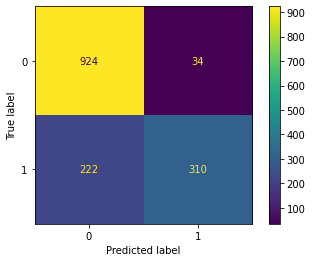

In [101]:
plot_confusion_matrix(xgb, X_train, y_train)  
plt.show() 

Conclusión: No se mejoran las métricas solicitadas con este modelo.

### 3) Propuesta y análisis simultáneo de modelos

Antes de pasar  este paso se analiza el balanceo del dataset original, pudiendo pensar que la razón de no poder mejorar las métricas viene por este motivo.

In [130]:
# Cantidad de categorías 1 y 0 para Label
train_df['TravelInsurance'].value_counts()

0    958
1    532
Name: TravelInsurance, dtype: int64

El dataset tiene un desbalanceo del 36% aproximadamente para la categoría `TravelInsurance=1`, por lo que decide trabajar en proponer otros modelos antes de balancear el dataset.

### Análisis de varios modelos simultáneos

In [123]:
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

cKNN = KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2).fit(X_train, y_train)
cDT = DecisionTreeClassifier(criterion = 'entropy', random_state = 0).fit(X_train, y_train)
cRF = RandomForestClassifier(n_estimators = 10, criterion ='entropy', random_state = 0).fit(X_train, y_train)
cNB = GaussianNB().fit(X_train, y_train)
cLoR = LogisticRegression(solver = 'liblinear', random_state = 0).fit(X_train, y_train)
cSVM = SVC(kernel = 'rbf', random_state=0).fit(X_train, y_train)

In [129]:
model_lst = [cKNN, cDT, cRF, cLoR, cNB, cSVM]

for model in model_lst:
    model_name = model.__class__.__name__
    y_pred = model.predict(X_train)
#     R2CV = cross_val_score(model, X_train, y_train, cv = 10, verbose = False).mean()
#     error = -cross_val_score(model, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error',verbose = False).mean()
    print('Model:', model_name)
#     print(accuracy_score(y_test, predict))
#     print(R2CV)
#     print(np.sqrt(error))
    print(classification_report(y_train, y_pred))
    print('*' * 30)

Model: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       958
           1       0.89      0.54      0.67       532

    accuracy                           0.81      1490
   macro avg       0.84      0.75      0.77      1490
weighted avg       0.83      0.81      0.80      1490

******************************
Model: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       958
           1       0.95      0.74      0.83       532

    accuracy                           0.89      1490
   macro avg       0.91      0.86      0.88      1490
weighted avg       0.90      0.89      0.89      1490

******************************
Model: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       958
           1       0.88      0.78      0.83       532

    accuracy                    

Se observa que los modelos con mejor desempeño son el DecisionTreeClassifier y RandomForestClassifier. 

PREGUNTA: EL MEJOR MODELO ES EL QUE EN EL PASO 1 NO PUDE MEJORAR, QUÉ PARÁMETROS PERJUDICAN AL ALGORITMO??? random_sta

### 4) Optimización de parámetros del modelo: ....

Pendiente: hacer algún tipo de GridSearchCV

## Generate the output

The last thing we do is generating a file that should be *submitted* on kaggle

In [14]:
test_id = test_df["Customer"]
test_pred = best_tree_clf.predict(X_test)

submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["Customer", "TravelInsurance"])
submission.to_csv("../data/travel_insurance_submission.csv", header=True, index=False)